In [106]:
import pandas as pd
import numpy as np 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import plot_roc_curve, roc_auc_score
from sklearn.tree import export_graphviz
from joblib import dump,load
import pydot



We will test to see if our data is imbalanced.

In [43]:
#random forests, Naive Bayes, XGBoost, and General Logistic Regression
#neural network with Keras

training_data = pd.read_csv("full_training_data_1988-2016")
#numbers of players in training data that are All-NBA players and aren't All-NBA players
counter = Counter(training_data.All_NBA)
print(counter)
#percentage of All-NBA
print("Percent All-NBA:",round(len(training_data.loc[training_data.All_NBA == True])/len(training_data.index)*100,2))
#percentage of non All-NBA
print("Percent not All-NBA:",round(len(training_data.loc[training_data.All_NBA == False])/len(training_data.index)*100,2))


Counter({False: 11784, True: 420})
Percent All-NBA: 3.44
Percent not All-NBA: 96.56


As we can see, the amount of players in our training data that aren't labeled as All-NBA are approx. 97% of our data. Therefore, our data is imbalanced. We will need to be balance our training data in order to help our classification algorithm. Therefore, we will perform SMOTE to synthetically build more examples of the minority class. In this instance, the minority class is the players that have made an All-NBA team.

In [44]:
X = training_data.iloc[:,1:-1].select_dtypes(exclude=['object'])
y = training_data["All_NBA"]


As we can see, the data is now equal. As mentioned in multiple articles, SMOTE works best with random under-sampling of the majority class. We have set up both SMOTE by itself and SMOTE with under-sampling.

We will first create a Random Forest model to predict All-NBA teams

In [45]:
#parameter grid to help with hyper-parameter tuning
param_grid = [
    {'n_estimators': [50,100,250,300,500],
     'criterion': ["gini","entropy"],
     'max_features': ['auto','log2'],
     'min_samples_leaf': [1,2,3,5]},
    ]

# cv = RepeatedStratifiedKFold(n_splits=10)
# train Random Forest
# rf = RandomForestClassifier()
# grid_search_rf = GridSearchCV(rf,param_grid=param_grid,cv=cv,n_jobs=-1)
#best model is 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 300} using cv for 5
#best model after KFold is {'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 250}

grid_search_rf = RandomForestClassifier(criterion='entropy',max_features='log2',min_samples_leaf=1,n_estimators=250)
grid_search_rf.fit(X,y=y)
# print(grid_search_rf.best_params_)


RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=250)

In [108]:
#function to calculate Top 15 All-NBA players
def grabTop15Players(dataframe1, dataframe2):
    guard_counter = 0
    forward_counter = 0
    center_counter = 0
    top_all_nba = []
    true_all_NBA = dataframe1.loc[dataframe1.All_NBA == True,"Player"]
    dataframe1["Predicted_Prob"] = grid_search_rf.predict_proba(dataframe2)[:,1]
    filtered_df = dataframe1.reindex(columns = ['Player','Pos','Predicted_Prob'])
    sorted_filtered_df = filtered_df.sort_values(by='Predicted_Prob',ascending=False).loc[filtered_df["Predicted_Prob"] != 0]   

    for player in range(len(sorted_filtered_df.index)):
        if sorted_filtered_df.iloc[player,:]["Pos"] == "PG" or sorted_filtered_df.iloc[player,:]["Pos"] == "SG":
            if(guard_counter < 6):
                top_all_nba.append(sorted_filtered_df.iloc[player,:]["Player"])
                guard_counter += 1
        elif sorted_filtered_df.iloc[player,:]["Pos"] == "SF" or sorted_filtered_df.iloc[player,:]["Pos"] == "PF":
            if(forward_counter < 6):
                top_all_nba.append(sorted_filtered_df.iloc[player,:]["Player"])
                forward_counter += 1
        elif sorted_filtered_df.iloc[player,:]["Pos"] == "C":
            if(center_counter < 3):
                top_all_nba.append(sorted_filtered_df.iloc[player,:]["Player"])
                center_counter += 1
    
    print("True Top 15 Players:",true_all_NBA)
    print("Predicted Top 15 Players:", top_all_nba)
    wrong_predict_players = [players for players in top_all_nba if players not in true_all_NBA.unique()]
    print("Top 15 predicted players who didn't make All-NBA:", wrong_predict_players)
    print()
    missed_players = [players for players in true_all_NBA.unique() if players not in top_all_nba]
    print("Top 15 players who werent predicted top 15:",missed_players)
    print()
    print("Percent correct of Top 15 Players:",(15-len(wrong_predict_players))/15)      
   
    


In [47]:
#testing random forest model on testing data
test_data = pd.read_csv("testing_data_2017-2020")
test_player_data_all = test_data.iloc[:,1:-1].select_dtypes(exclude=['object'])
test_player_class_all = test_data["All_NBA"]

2017 Data

0.9794238683127572
86            Mike Conley
89       DeMarcus Cousins
184        Gordon Hayward
214          Kyrie Irving
265        Damian Lillard
273            Kyle Lowry
350            Chris Paul
433    Karl-Anthony Towns
Name: Player, dtype: object

163    Draymond Green
239    DeAndre Jordan
Name: Player, dtype: object

0.9935598018400567


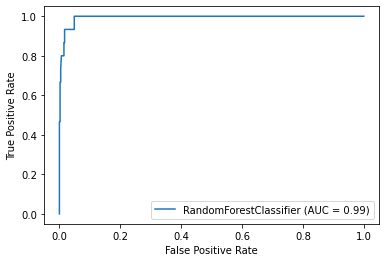

Top 15 predicted players who didn't make All-NBA: ['Karl-Anthony Towns', 'DeMarcus Cousins', 'Gordon Hayward']

Top 15 players who werent predicted top 15: ['Rudy Gobert', 'Draymond Green', 'DeAndre Jordan']

Percent correct of Top 15 Players: 0.8


In [48]:
#testing 2017 data
test_data2017 = test_data[test_data['Year'] == 2017]
test_player_data2017 = test_data2017.iloc[:,1:-1].select_dtypes(exclude=['object'])
test_player_class2017 = test_data2017["All_NBA"]

print(grid_search_rf.score(test_player_data2017,test_player_class2017))
predicted_y = grid_search_rf.predict(test_player_data2017)
test_data2017["Predicted_All_NBA"] = predicted_y

# predict_all_nba = test_data2017.loc[test_data2017.Predicted_All_NBA == True,"Player"]

#players predicted to be on All-NBA and were not on All-NBA
print(test_data2017.loc[(test_data2017.All_NBA == False) & (test_data2017.Predicted_All_NBA == True),"Player"])
print()
#players predicted not to be on All-NBA and was listed on All-NBA
print(test_data2017.loc[(test_data2017.All_NBA == True) & (test_data2017.Predicted_All_NBA == False),"Player"])
print()

# compute ROC AUC score
print(roc_auc_score(test_player_class2017,grid_search_rf.predict_proba(test_player_data2017)[:,1]))
#plot ROC Curve
plot_roc_curve(grid_search_rf, test_player_data2017,test_player_class2017)
plt.show()

#Calculate Top 15 All-NBA and get percentage
grabTop15Players(test_data2017,test_player_data2017)


2018 Data

0.9888888888888889
492        LaMarcus Aldridge
501    Giannis Antetokounmpo
564             Jimmy Butler
605            Stephen Curry
607            Anthony Davis
615            DeMar DeRozan
628             Kevin Durant
632              Joel Embiid
658              Paul George
679             James Harden
733             LeBron James
783           Damian Lillard
867           Victor Oladipo
969       Karl-Anthony Towns
993        Russell Westbrook
Name: Player, dtype: object

492        LaMarcus Aldridge
501    Giannis Antetokounmpo
564             Jimmy Butler
605            Stephen Curry
607            Anthony Davis
628             Kevin Durant
679             James Harden
724             Kyrie Irving
733             LeBron James
748             Nikola Jokić
783           Damian Lillard
867           Victor Oladipo
881               Chris Paul
969       Karl-Anthony Towns
993        Russell Westbrook
Name: Player, dtype: object

724    Kyrie Irving
748    Nikola Jokić
881      Chri

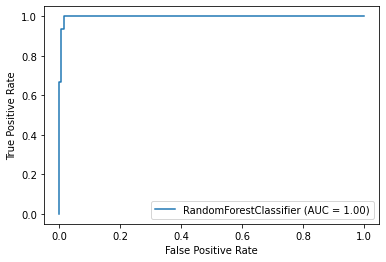

In [49]:
#testing 2018 data
test_data2018 = test_data[test_data['Year'] == 2018]
test_player_data2018 = test_data2018.iloc[:,1:-1].select_dtypes(exclude=['object'])
test_player_class2018 = test_data2018["All_NBA"]

print(grid_search_rf.score(test_player_data2018,test_player_class2018))
predicted_y = grid_search_rf.predict(test_player_data2018)
test_data2018["Predicted_All_NBA"] = predicted_y

print(test_data2018.loc[test_data2018.All_NBA == True,"Player"])
print()
print(test_data2018.loc[test_data2018.Predicted_All_NBA == True,"Player"])
print()
#players predicted to be on All-NBA and were not on All-NBA
print(test_data2018.loc[(test_data2018.All_NBA == False) & (test_data2018.Predicted_All_NBA == True),"Player"])
print()
#players predicted not to be on All-NBA and was listed on All-NBA
print(test_data2018.loc[(test_data2018.All_NBA == True) & (test_data2018.Predicted_All_NBA == False),"Player"])


#compute ROC AUC score
print(roc_auc_score(test_player_class2018,grid_search_rf.predict_proba(test_player_data2018)[:,1]))
#plot ROC Curve
plot_roc_curve(grid_search_rf, test_player_data2018,test_player_class2018)

#Calculate Top 15 All-NBA and get percentage
grabTop15Players(test_data2018,test_player_data2018)


2019 Data

0.9905660377358491
1043    Giannis Antetokounmpo
1149            Stephen Curry
1175             Kevin Durant
1180              Joel Embiid
1208              Paul George
1212              Rudy Gobert
1227            Blake Griffin
1231             James Harden
1274             Kyrie Irving
1283             LeBron James
1294             Nikola Jokić
1326            Kawhi Leonard
1330           Damian Lillard
1522             Kemba Walker
1531        Russell Westbrook
Name: Player, dtype: object

1043    Giannis Antetokounmpo
1149            Stephen Curry
1151            Anthony Davis
1175             Kevin Durant
1180              Joel Embiid
1208              Paul George
1212              Rudy Gobert
1231             James Harden
1274             Kyrie Irving
1283             LeBron James
1294             Nikola Jokić
1326            Kawhi Leonard
1330           Damian Lillard
1506       Karl-Anthony Towns
1518           Nikola Vučević
1531        Russell Westbrook
Name: Player, dtype: o

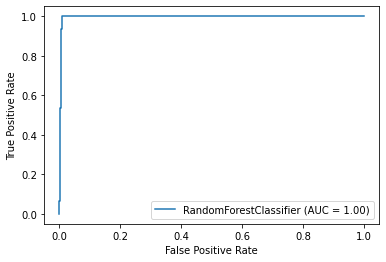

In [50]:
#testing 2019 data
test_data2019 = test_data[test_data['Year'] == 2019]
test_player_data2019 = test_data2019.iloc[:,1:-1].select_dtypes(exclude=['object'])
test_player_class2019 = test_data2019["All_NBA"]

print(grid_search_rf.score(test_player_data2019,test_player_class2019))
predicted_y = grid_search_rf.predict(test_player_data2019)
test_data2019["Predicted_All_NBA"] = predicted_y

print(test_data2019.loc[test_data2019.All_NBA == True,"Player"])
print()
print(test_data2019.loc[test_data2019.Predicted_All_NBA == True,"Player"])
print()
#players predicted to be on All-NBA and were not on All-NBA
print(test_data2019.loc[(test_data2019.All_NBA == False) & (test_data2019.Predicted_All_NBA == True),"Player"])
print()
#players predicted not to be on All-NBA and was listed on All-NBA
print(test_data2019.loc[(test_data2019.All_NBA == True) & (test_data2019.Predicted_All_NBA == False),"Player"])
print()

#compute ROC AUC score
print(roc_auc_score(test_player_class2019,grid_search_rf.predict_proba(test_player_data2019)[:,1]))
#plot ROC Curve
plot_roc_curve(grid_search_rf, test_player_data2019,test_player_class2019)

#Calculate Top 15 All-NBA and get percentage
grabTop15Players(test_data2019,test_player_data2019)


2020 Data

0.9867674858223062
1568    Giannis Antetokounmpo
1637             Jimmy Butler
1678            Anthony Davis
1689              Luka Dončić
1731              Rudy Gobert
1753             James Harden
1805             LeBron James
1816             Nikola Jokić
1849            Kawhi Leonard
1852           Damian Lillard
1951               Chris Paul
2004            Pascal Siakam
2006              Ben Simmons
2019             Jayson Tatum
2061        Russell Westbrook
Name: Player, dtype: object

1568    Giannis Antetokounmpo
1678            Anthony Davis
1689              Luka Dončić
1753             James Harden
1805             LeBron James
1816             Nikola Jokić
1849            Kawhi Leonard
1852           Damian Lillard
Name: Player, dtype: object

Series([], Name: Player, dtype: object)

1637         Jimmy Butler
1731          Rudy Gobert
1951           Chris Paul
2004        Pascal Siakam
2006          Ben Simmons
2019         Jayson Tatum
2061    Russell Westbrook
Name: Play

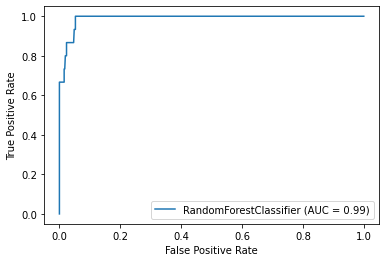

Top 15 predicted players who didn't make All-NBA: ['Bradley Beal', 'Joel Embiid', 'Domantas Sabonis', 'Khris Middleton']

Top 15 players who werent predicted top 15: ['Chris Paul', 'Pascal Siakam', 'Ben Simmons', 'Jayson Tatum']

Percent correct of Top 15 Players: 0.7333333333333333


In [51]:
#testing 2020 data
test_data2020 = test_data[test_data['Year'] == 2020]
test_player_data2020 = test_data2020.iloc[:,1:-1].select_dtypes(exclude=['object'])
test_player_class2020 = test_data2020["All_NBA"]

print(grid_search_rf.score(test_player_data2020,test_player_class2020))
predicted_y = grid_search_rf.predict(test_player_data2020)
test_data2020["Predicted_All_NBA"] = predicted_y

print(test_data2020.loc[test_data2020.All_NBA == True,"Player"])
print()
print(test_data2020.loc[test_data2020.Predicted_All_NBA == True,"Player"])
print()
#players predicted to be on All-NBA and were not on All-NBA
print(test_data2020.loc[(test_data2020.All_NBA == False) & (test_data2020.Predicted_All_NBA == True),"Player"])
print()
#players predicted not to be on All-NBA and was listed on All-NBA
print(test_data2020.loc[(test_data2020.All_NBA == True) & (test_data2020.Predicted_All_NBA == False),"Player"])
print()

#compute ROC AUC score
print(roc_auc_score(test_player_class2020,grid_search_rf.predict_proba(test_player_data2020)[:,1]))
#plot ROC Curve
plot_roc_curve(grid_search_rf, test_player_data2020,test_player_class2020)
plt.show()

#Calculate Top 15 All-NBA and get percentage
grabTop15Players(test_data2020,test_player_data2020)

Variable: WS_advanced, Importance:0.0779
Variable: PER_advanced, Importance:0.0671
Variable: VORP_advanced, Importance:0.0598
Variable: PTS_per_game, Importance:0.0545
Variable: FG_per_game, Importance:0.0472
Variable: BPM_advanced, Importance:0.0446
Variable: FT_per_game, Importance:0.0375
Variable: WS/48_advanced, Importance:0.0371
Variable: OWS_advanced, Importance:0.0332
Variable: OBPM_advanced, Importance:0.0313
Variable: 2P_per_game, Importance:0.0257
Variable: DWS_advanced, Importance:0.0253
Variable: MP, Importance:0.024
Variable: FTA_per_game, Importance:0.0228
Variable: PTS_per_poss, Importance:0.0181
Variable: 2PA_per_game, Importance:0.0168
Variable: FGA_per_game, Importance:0.0159
Variable: TOV_per_game, Importance:0.0154
Variable: PTS_per_minute, Importance:0.0142
Variable: FG_per_poss, Importance:0.0142
Variable: FG_per_minute, Importance:0.0137
Variable: DRB_per_game, Importance:0.0101
Variable: 2P_per_poss, Importance:0.0099
Variable: USG%_advanced, Importance:0.0099
V

([<matplotlib.axis.XTick at 0x7f9cacb9b7c0>,
 [Text(0, 0, 'WS_advanced'),
  Text(0, 0, 'PER_advanced'),
  Text(0, 0, 'VORP_advanced'),
  Text(0, 0, 'PTS_per_game'),
  Text(0, 0, 'FG_per_game'),
  Text(0, 0, 'BPM_advanced'),
  Text(0, 0, 'FT_per_game'),
  Text(0, 0, 'WS/48_advanced'),
  Text(0, 0, 'OWS_advanced'),
  Text(0, 0, 'OBPM_advanced'),
  Text(0, 0, '2P_per_game'),
  Text(0, 0, 'DWS_advanced'),
  Text(0, 0, 'MP'),
  Text(0, 0, 'FTA_per_game'),
  Text(0, 0, 'PTS_per_poss')])

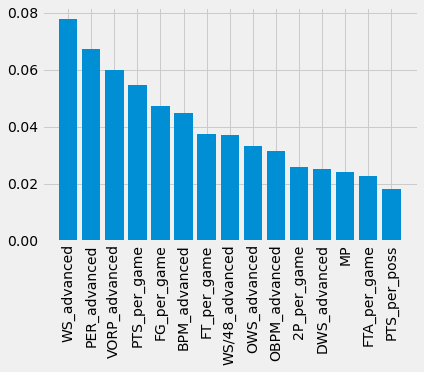

In [93]:
#calculating feature importance
importances = grid_search_rf.feature_importances_

feature_importances = [(feature,round(importance,4)) for feature, importance in zip(list(X.columns),importances)]

sorted_features = sorted(feature_importances,key= lambda x: x[1], reverse=True)
[print("Variable: {}, Importance:{}".format(*pair)) for pair in sorted_features]

plt.style.use("fivethirtyeight")
#un-sorted columns
# x_values = list(range(len(importances)))
# plt.bar(x_values,list(importances),tick_label=X.columns)

#sorted columns
sorted_feature_names = [name[0] for name in sorted_features]
sorted_feature_values = [value[1] for value in sorted_features]
print(sorted_feature_values)

plt.bar(list(range(15)),sorted_feature_values[:15])
plt.xticks(list(range(15)),sorted_feature_names[:15],rotation='vertical')





Save model for further use

In [54]:
dump(grid_search_rf,"grid_rf.joblib")

['grid_rf.joblib']

Creating Image of Random Forest

In [107]:
#choose random tree to visualize
rand_num = np.random.randint(250)
tree = grid_search_rf.estimators_[rand_num]

export_graphviz(tree,out_file = 'tree.dot',feature_names=X.columns)
(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png

